In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
from utils import check_paths
import pandas as pd
from scipy.io import loadmat
%matplotlib qt

from pactools import Comodulogram, REFERENCES, raw_to_mask
from pactools import simulate_pac

In [2]:
eeg_data_dir = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set'
group_save_path = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y group'
sub_name = 'ALL_subs'
task = '_MAIN' # ['_BL', '_MAIN']
block_name = '_baseline' # ['_baseline', '_adaptation']
task_stage = '_go' # '_plan' or '_go'
epochs_all_subs = mne.read_epochs(os.path.join(group_save_path, f"{sub_name}{task}_epochs{task_stage}{block_name}_ALL-epo.fif"), preload=True)
epochs_all_subs

Reading D:\BonoKat\research project\# study 1\eeg_data\set\Y group\ALL_subs_MAIN_epochs_go_baseline_ALL-epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -500.00 ...     700.00 ms
        0 CTF compensation matrices available
Adding metadata with 16 columns
933 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


<EpochsFIF | 933 events (all good), -0.5 – 0.7 s (baseline -0.5 – 0.7 s), ~261.0 MB, data loaded, with metadata,
 'go_on': 933>

In [3]:
# Extract only EEG channel names from the Epochs object
eeg_channel_names = epochs_all_subs.copy().pick("eeg").ch_names
# print(eeg_channel_names)

# Select sensorimotor channels
choi = ['Fp1', 'Fp2', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'AF3', 'AF4', 'AF7', 'AF8',
        'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6']

epochs_all_subs.pick(choi)

<EpochsFIF | 933 events (all good), -0.5 – 0.7 s (baseline -0.5 – 0.7 s), ~128.4 MB, data loaded, with metadata,
 'go_on': 933>

In [4]:
sf = epochs_all_subs.info['sfreq']  # Sampling frequency
times = epochs_all_subs.times

In [5]:
theta_range = np.linspace(4, 8, 20)  # Phase: 4-8 Hz
gamma_range = np.linspace(30, 80, 20)  # Amplitude: 30-80 Hz

In [ ]:
# # set freqs for PAC analysis
# width, step = 3, .2
# theta = [3, 9]
# alpha = [6, 14]
# lower_gamma = (30, 50, 2, 0.5)
# higher_gamma = (50, 80, 2, 0.5)

In [6]:
data = epochs_all_subs.get_data()[:,0,:]
data.shape

(933, 601)

In [21]:
data

array([[ 1.00958299e-05,  1.30139093e-05,  1.06715202e-05, ...,
        -2.77992941e-06, -3.42526531e-06, -2.68632790e-06],
       [ 7.21202801e-06,  2.34716009e-06, -1.80564964e-06, ...,
        -1.30930175e-05, -1.15997057e-05, -1.09947900e-05],
       [ 2.72846102e-06,  5.19179773e-06,  5.22831296e-06, ...,
         3.40038371e-06,  1.27161429e-06,  2.70490097e-06],
       ...,
       [ 1.22367611e-05,  1.37181902e-05,  9.50410744e-06, ...,
         4.64171313e-06,  4.00154018e-06,  1.94311881e-06],
       [-3.76213503e-06, -6.22428795e-06, -6.95758964e-06, ...,
        -2.12315368e-06, -7.84659445e-07,  2.02760916e-07],
       [-9.16105936e-06, -1.09501714e-05, -9.15327452e-06, ...,
        -2.04538534e-06,  1.68466107e-06,  1.19665814e-06]])

In [19]:
data = data.squeeze(axis=1)
data.shape

(933, 601)

In [7]:
from mne.filter import filter_data

# Define frequency bands
theta_band = (4, 8)  # Hz
gamma_band = (30, 80)  # Hz

# Get data for a specific channel (e.g., Cz)
ch_name = 'C2'
data = epochs_all_subs.get_data(picks=ch_name)  # Shape: (n_epochs, n_times)

# Get the sampling frequency
sfreq = epochs_all_subs.info["sfreq"]

# Apply bandpass filtering for phase (theta)
low_sig = filter_data(data, sfreq, theta_band[0], theta_band[1], method="fir")

# Apply bandpass filtering for amplitude (gamma)
high_sig = filter_data(data, sfreq, gamma_band[0], gamma_band[1], method="fir")

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)

Setting up band-pass filter from 30 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Fil

C:\Users\a1902989\AppData\Local\Temp\ipykernel_34416\1041727239.py:15: RuntimeWarning: filter_length (825) is longer than the signal (601), distortion is likely. Reduce filter length or filter a longer signal.
  low_sig = filter_data(data, sfreq, theta_band[0], theta_band[1], method="fir")
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks  

In [8]:
low_sig = low_sig.squeeze(axis=1)  # Shape: (734, 501)
high_sig = high_sig.squeeze(axis=1)  # Shape: (734, 501)

In [21]:
# create the instance of Comodulogram
estimator = Comodulogram(fs=sf,
                        low_fq_range=theta_range,  # Phase frequencies (theta)
                        high_fq_range=gamma_range, # Amplitude frequencies (gamma)
                        method='tort',
                        progress_bar=True)
# compute the comodulogram
pac = estimator.fit(data, data)
# plot the results
estimator.plot(tight_layout=False)
plt.show()

[........................................] 100% | 6.99 sec | comodulogram: tort 


In [ ]:
pac = estimator.fit(data, data)
pac1 = estimator.fit(low_sig, high_sig)

In [23]:
pac == pac1

True

In [47]:
estimator.get_maximum_pac()

(array([7.57894737]), array([51.05263158]), array([2.77943771e-05]))

In [37]:
data[733].shape

(250,)

In [ ]:
for chan in range(1): # range(len(choi))
    # Load the data from an MNE Epochs object (e.g., shape: epochs x channels x time)
    time_all = slice(250, 500) # 0s-0.5s
    data = epochs_all_subs.get_data()[:,chan,time_all]  # Shape: (n_epochs, n_channels, n_times)

    print(f"DATA: (n_trials, n_times)={data.shape}; SAMPLING FREQUENCY={sf}Hz; "
        f"TIME VECTOR: n_times={len(times)}")
    
    

    for f_pha in [theta, alpha]: # [theta, alpha]
        print(f_pha)

        if f_pha == theta:
            phase_name = 'theta'
            amp_name = 'lower gamma'
            f_amp = lower_gamma
        else:
            phase_name = 'alpha'
            amp_name = 'higher gamma'
            f_amp = higher_gamma


In [3]:
fs = 200.  # Hz
high_fq = 50.0  # Hz
low_fq = 5.0  # Hz
low_fq_width = 1.0  # Hz

n_points = 10000
noise_level = 0.4

signal = simulate_pac(n_points=n_points, fs=fs, high_fq=high_fq, low_fq=low_fq,
                      low_fq_width=low_fq_width, noise_level=noise_level,
                      random_state=0)

In [6]:
signal

array([ 0.23248289,  0.71442597,  1.07336052, ...,  1.00246836,
       -0.15827975, -0.58094172])

In [ ]:
low_fq_range = np.linspace(3, 9, 25)
methods = ['canolty', 'tort', 'penny']

ozkurt... 
canolty... 
tort... 
penny... 
vanwijk... 
duprelatour... 
colgin... 


NotImplementedError: `interp2d` has been removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
https://scipy.github.io/devdocs/tutorial/interpolate/interp_transition_guide.html


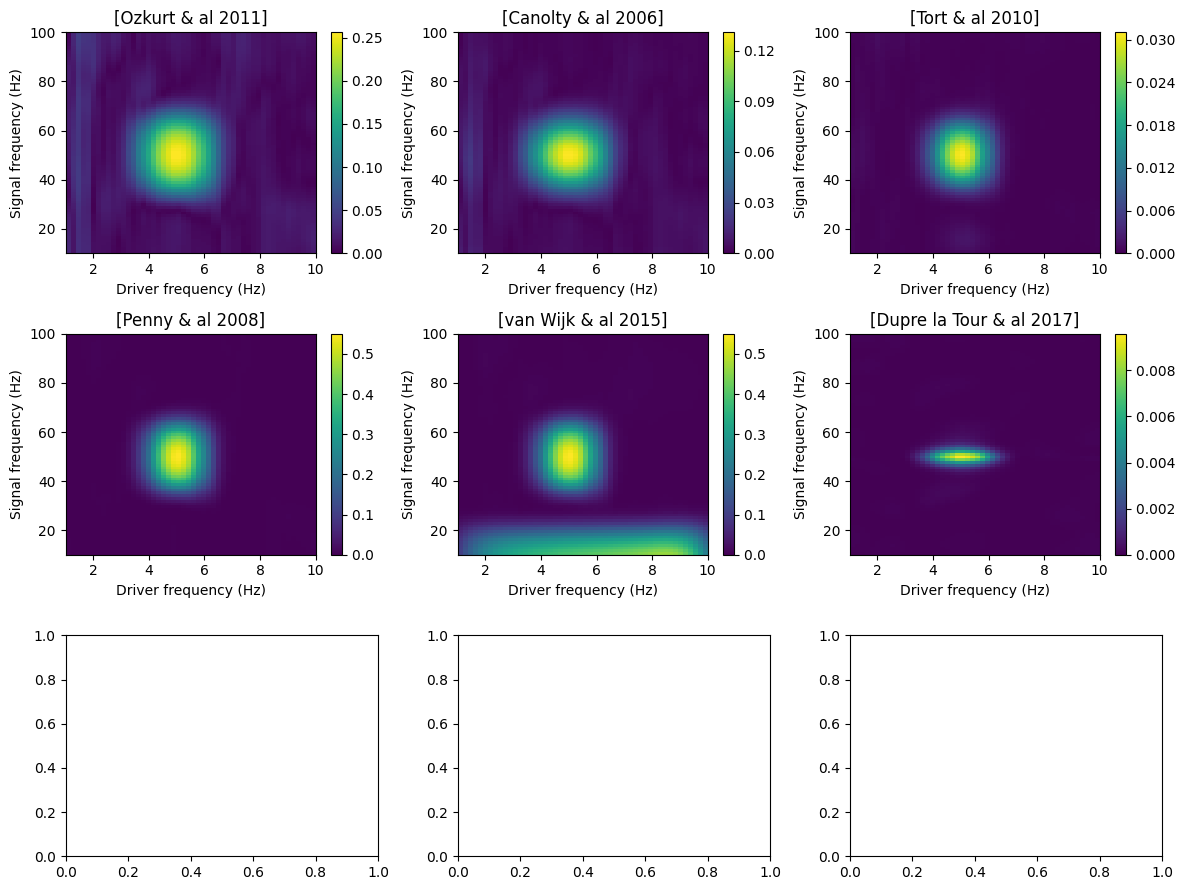

In [ ]:
# Define the subplots where the comodulogram will be plotted
n_lines = 3
n_columns = int(np.ceil(len(methods) / float(n_lines)))
fig, axs = plt.subplots(
    n_lines, n_columns, figsize=(4 * n_columns, 3 * n_lines))
axs = axs.ravel()


# Compute the comodulograms and plot them
for ax, method in zip(axs, methods):
    print('%s... ' % (method, ))
    estimator = Comodulogram(fs=sf, low_fq_range=low_fq_range,
                             low_fq_width=low_fq_width, method=method,
                             progress_bar=False)
    estimator.fit(signal)
    estimator.plot(titles=[REFERENCES[method]], axs=[ax])

plt.show()